In [1]:
#mounting the drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks")

In [3]:
%cd Intern Academy/SpeechEmotionRecognition/

/content/drive/My Drive/Colab Notebooks/Intern Academy/SpeechEmotionRecognition


In [4]:
!ls

archive.zip  Crema  Ravdess  Savee  Tess


## Importing Packages

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.io import wavfile
import os.path
import IPython.display
import seaborn as sns
import librosa
import librosa.display
import soundfile

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from keras import optimizers

import warnings

## Loading Data

In [6]:
audio_dir = Path('Crema')
filename = list(audio_dir.glob(r'**/*.wav'))
labels = list(map(lambda x: os.path.split(x)[1].split('_')[2], filename))
set(labels)

{'ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD'}

In [7]:
filename = pd.Series(filename, name='FileName').astype(str)
labels = pd.Series(labels, name='Label')

audio_df = pd.concat([filename, labels], axis=1)
audio_df

,FileName,Label
0,Crema/1079_TIE_FEA_XX.wav,FEA
1,Crema/1079_TIE_HAP_XX.wav,HAP
2,Crema/1079_TIE_NEU_XX.wav,NEU
3,Crema/1079_TIE_SAD_XX.wav,SAD
4,Crema/1079_TSI_ANG_XX.wav,ANG
...,...,...
7437,Crema/1006_IOM_SAD_XX.wav,SAD
7438,Crema/1006_ITH_DIS_XX.wav,DIS
7439,Crema/1006_ITH_FEA_XX.wav,FEA
7440,Crema/1006_ITH_NEU_XX.wav,NEU


## Data Visualization

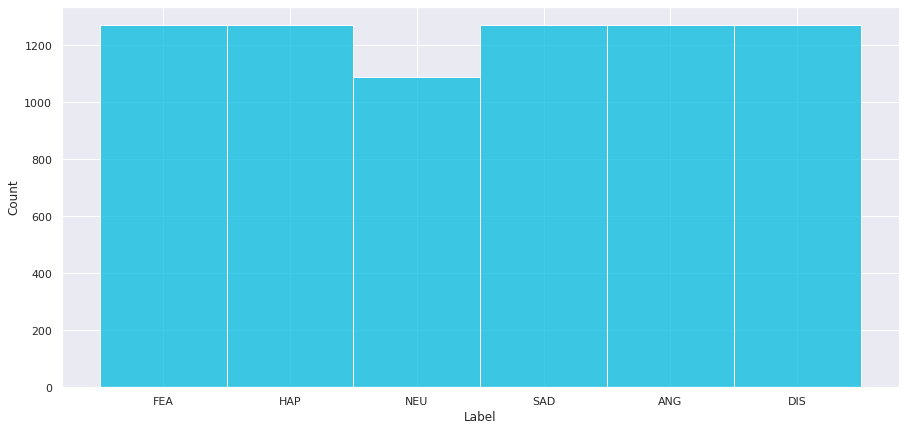

In [8]:
sns.set(rc={'figure.figsize':(15,7)})
sns.set_style('darkgrid')
sns.histplot(labels, color='#00BCE0')

In [9]:
audio_arrays = []

for i in audio_df['FileName']:
    x, sr = librosa.load(i, sr=44100)
    audio_arrays.append(x)
    
audio_df['Arrays'] = audio_arrays

In [10]:
audio_df

,FileName,Label,Arrays
0,Crema/1079_TIE_FEA_XX.wav,FEA,"[-0.0031820564, -0.0033416762, -0.003138107, -..."
1,Crema/1079_TIE_HAP_XX.wav,HAP,"[-0.0029986033, -0.0036278854, -0.0037290812, ..."
2,Crema/1079_TIE_NEU_XX.wav,NEU,"[-0.0064317016, -0.0072204527, -0.0069183703, ..."
3,Crema/1079_TIE_SAD_XX.wav,SAD,"[-0.00081002834, -0.00075216906, -0.0005986087..."
4,Crema/1079_TSI_ANG_XX.wav,ANG,"[-0.0053054173, -0.005964947, -0.005845291, -0..."
...,...,...,...
7437,Crema/1006_IOM_SAD_XX.wav,SAD,"[0.0014635584, 0.0017636337, 0.0016795307, 0.0..."
7438,Crema/1006_ITH_DIS_XX.wav,DIS,"[0.010019741, 0.011124266, 0.010423021, 0.0091..."
7439,Crema/1006_ITH_FEA_XX.wav,FEA,"[0.0028706258, 0.003417499, 0.0034766921, 0.00..."
7440,Crema/1006_ITH_NEU_XX.wav,NEU,"[0.010258526, 0.012161536, 0.012175254, 0.0112..."


### `Anger😡`

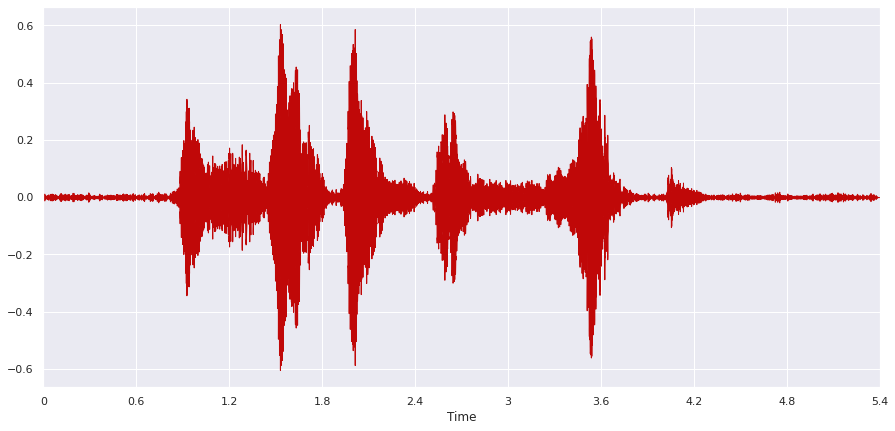

In [12]:
angfile = audio_df[audio_df['Label'] == 'ANG']['FileName']
angarray = audio_df[audio_df['Label'] == 'ANG']['Arrays']

librosa.display.waveplot(angarray.iloc[0], color='#C00808')
IPython.display.Audio(angfile.iloc[0])

### `Disgust🥴`

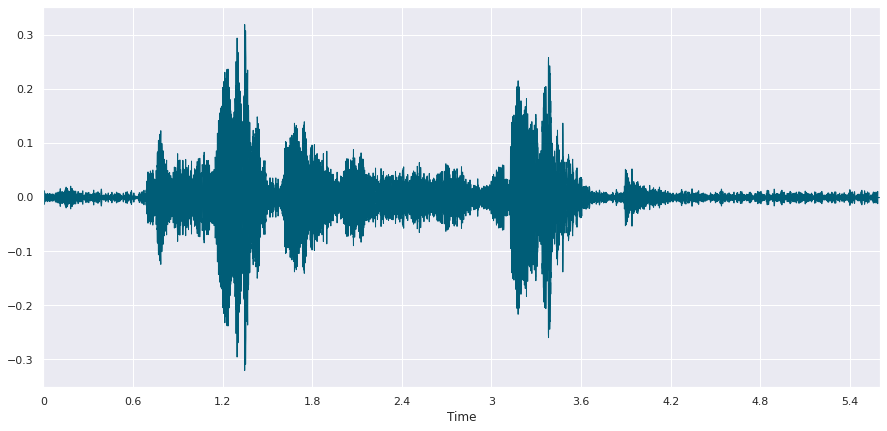

In [14]:
disfile = audio_df[audio_df['Label'] == 'DIS']['FileName']
disarray = audio_df[audio_df['Label'] == 'DIS']['Arrays']

librosa.display.waveplot(disarray.iloc[0], color='#005D77')
IPython.display.Audio(disfile.iloc[0])

### `Fear😨`

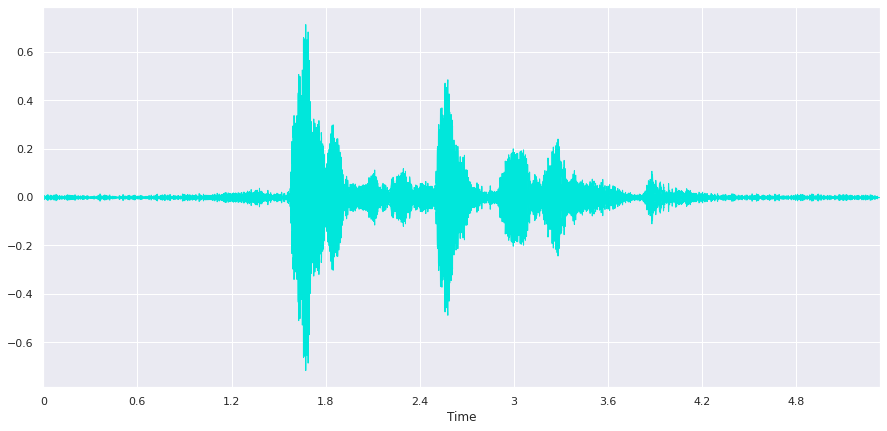

In [15]:
feafile = audio_df[audio_df['Label'] == 'FEA']['FileName']
feaarray = audio_df[audio_df['Label'] == 'FEA']['Arrays']

librosa.display.waveplot(feaarray.iloc[0], color='#00E7DB')
IPython.display.Audio(feafile.iloc[0])

### `Happiness😄`

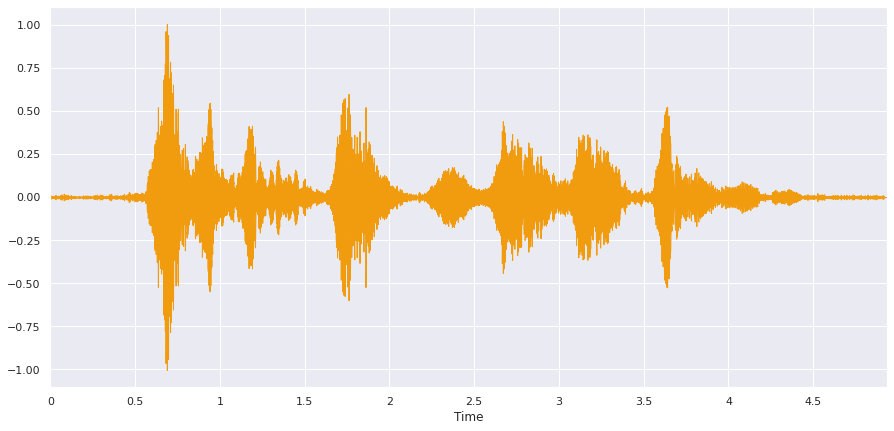

In [16]:
hapfile = audio_df[audio_df['Label'] == 'HAP']['FileName']
haparray = audio_df[audio_df['Label'] == 'HAP']['Arrays']

librosa.display.waveplot(haparray.iloc[0], color='#F19C0E')
IPython.display.Audio(hapfile.iloc[0])

### `Neutral😐`

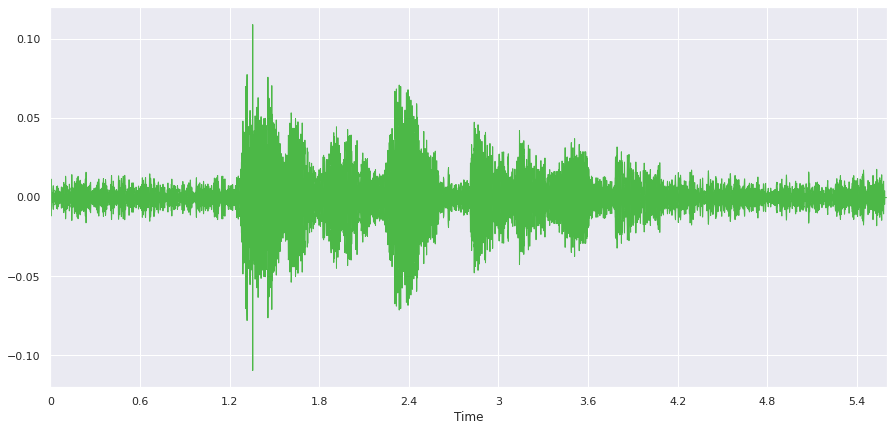

In [17]:
neufile = audio_df[audio_df['Label'] == 'NEU']['FileName']
neuarray = audio_df[audio_df['Label'] == 'NEU']['Arrays']

librosa.display.waveplot(neuarray.iloc[0], color='#4CB847')
IPython.display.Audio(neufile.iloc[0])

### `Sadness☹️`

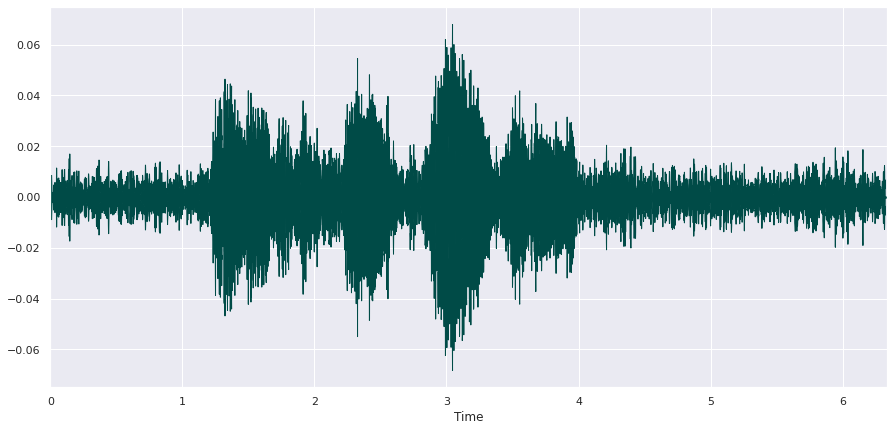

In [18]:
sadfile = audio_df[audio_df['Label'] == 'SAD']['FileName']
sadarray = audio_df[audio_df['Label'] == 'SAD']['Arrays']

librosa.display.waveplot(sadarray.iloc[0], color='#004B47')
IPython.display.Audio(sadfile.iloc[0])

## Data Augmentation

In [19]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

## Feature Extraction

In [20]:
def extract_features(data):
    # Zero Crossing Rate
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr))

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr, n_fft=200).T, axis=0)
    result = np.hstack((result, chroma_stft))     

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_fft=200).T, axis=0)
    result = np.hstack((result, mfcc))

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sr, n_fft=200).T, axis=0)
    result = np.hstack((result, mel))
    
    # Tonnetz
    tonnetz = np.mean(librosa.feature.tonnetz(y=data, sr=sr).T, axis=0);
    result = np.hstack((result, tonnetz));
    
    return result

In [21]:
def get_features(data):
    result = []
    
    # without augmentation
    res1 = extract_features(data)
    result.append(res1)
    
    # with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result.append(res2)
    
    # with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sr)
    res3 = extract_features(data_stretch_pitch)
    result.append(res3)
    
    return result

In [22]:
warnings.filterwarnings('ignore')

x = []
y = []
for i in range(len(audio_df)):
    feature=get_features(audio_df['Arrays'].iloc[i]);
    for j in feature:
        x.append(j)
        y.append(audio_df['Label'].iloc[i])

In [23]:
le = LabelEncoder()
y = utils.to_categorical(le.fit_transform(y))
y

array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

## Train Test Split

In [24]:
x_train, x_test, y_train, y_test = train_test_split(np.array(x), np.array(y), test_size=0.1)

In [25]:
print((x_train.shape, y_train.shape, x_test.shape, y_test.shape))


((20093, 167), (20093, 6), (2233, 167), (2233, 6))


In [26]:
x_train = np.expand_dims(x_train,axis=2)
x_test = np.expand_dims(x_test,axis=2)

In [27]:
print((x_train.shape, y_train.shape, x_test.shape, y_test.shape))


((20093, 167, 1), (20093, 6), (2233, 167, 1), (2233, 6))


## Creating a model

In [28]:
model = Sequential()
model.add(Conv1D(128, 3, activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D((1)))
model.add(Conv1D(256, 3, activation='relu'))
model.add(MaxPooling1D((1)))
model.add(Conv1D(512, 3, activation='relu'))
model.add(MaxPooling1D((1)))
model.add(Conv1D(1024, 3, activation='relu'))
model.add(MaxPooling1D((1)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.RMSprop(lr=0.0005),
             metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 165, 128)          512       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 165, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 163, 256)          98560     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 163, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 161, 512)          393728    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 161, 512)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 159, 1024)         1

In [31]:
history = model.fit(x_train, y_train,
                    epochs=50,
                    batch_size=64,
                    validation_data=(x_test, y_test))

Epoch 1/50
314/314 [==============================] - 26s 83ms/step - loss: 1.4311 - accuracy: 0.4128 - val_loss: 1.3812 - val_accuracy: 0.4420
Epoch 2/50
314/314 [==============================] - 25s 81ms/step - loss: 1.4103 - accuracy: 0.4252 - val_loss: 1.3993 - val_accuracy: 0.4326
Epoch 3/50
314/314 [==============================] - 26s 81ms/step - loss: 1.3980 - accuracy: 0.4308 - val_loss: 1.3780 - val_accuracy: 0.4375
Epoch 4/50
314/314 [==============================] - 26s 82ms/step - loss: 1.3889 - accuracy: 0.4336 - val_loss: 1.3626 - val_accuracy: 0.4451
Epoch 5/50
314/314 [==============================] - 26s 82ms/step - loss: 1.3750 - accuracy: 0.4422 - val_loss: 1.3560 - val_accuracy: 0.4353
Epoch 6/50
314/314 [==============================] - 26s 82ms/step - loss: 1.3616 - accuracy: 0.4466 - val_loss: 1.3439 - val_accuracy: 0.4595
Epoch 7/50
314/314 [==============================] - 26s 82ms/step - loss: 1.3565 - accuracy: 0.4530 - val_loss: 1.3765 - val_accuracy:

## Model Evaluation

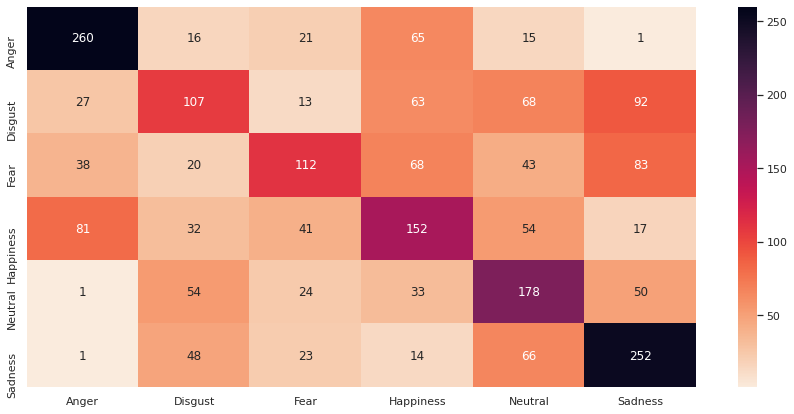

In [44]:
y_pred = model.predict(x_test)
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
ax = sns.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r', xticklabels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness'], yticklabels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness'])

In [45]:
from sklearn.metrics import classification_report
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.64      0.69      0.66       378
           1       0.39      0.29      0.33       370
           2       0.48      0.31      0.37       364
           3       0.38      0.40      0.39       377
           4       0.42      0.52      0.47       340
           5       0.51      0.62      0.56       404

    accuracy                           0.48      2233
   macro avg       0.47      0.47      0.46      2233
weighted avg       0.47      0.48      0.47      2233

